<a href="https://www.kaggle.com/code/mdsjaomdsjao/accident-risk-predictions-with-xgboost?scriptVersionId=270320837" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/mdsjaomdsjao/accident-risk-predictions-with-xgboost?scriptVersionId=270279194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

# Overview and Plotting

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv',)
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')

In [3]:
train.head(3)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30


In [4]:
train.sample(2)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
100927,100927,highway,4,0.35,25,daylight,rainy,False,False,evening,False,False,0,0.28
484239,484239,urban,3,0.75,45,night,rainy,True,False,afternoon,True,True,1,0.43


In [5]:
test.head(3)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1


In [6]:
train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [8]:
train['accident_risk'].describe()

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

In [9]:
train.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [10]:
num = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
boolean = ['road_signs_present','public_road','holiday','school_season']
categorical = ['road_type','lighting','weather','time_of_day']

In [11]:
train.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

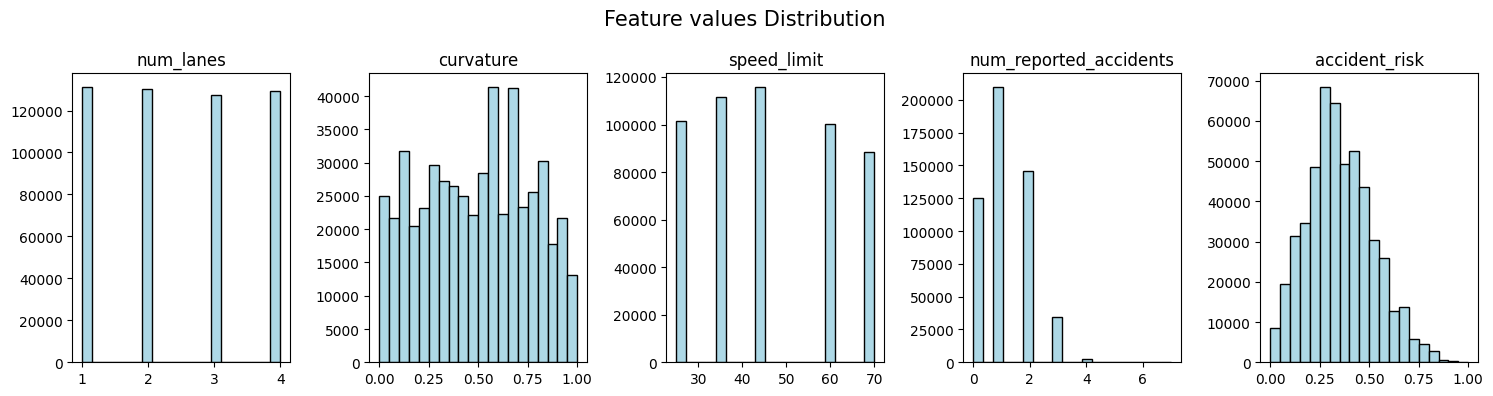

In [12]:
names = [ 'num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents','accident_risk']

fig, axs = plt.subplots(1, 5, figsize=(15, 4)) 
for i in range(0,5):
    axs[i].hist(train[names[i]], bins=20, color='lightblue', edgecolor='black')
    axs[i].set_title(names[i])

plt.suptitle('Feature values Distribution', fontsize= 15)
plt.tight_layout()
plt.show()

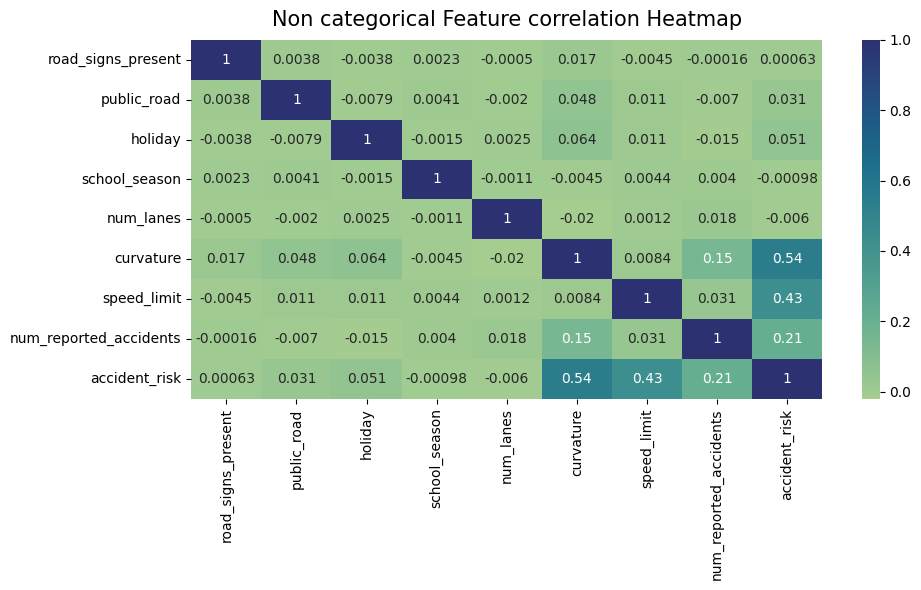

In [13]:
fig, ax = plt.subplots(figsize=(10,6))


cols = boolean+num+['accident_risk']
corr = train[cols].corr()

sns.heatmap(corr, cmap = 'crest', annot = True)
plt.title('Non categorical Feature correlation Heatmap',fontsize = 15, pad=10)
plt.tight_layout()
plt.show()

# Using Machine Learning Model

In [14]:
X = train.drop(['id','accident_risk'], axis=1)
y = train['accident_risk']

X_test = test.copy().drop(columns=['id'], axis=1)

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [16]:
#preprocessor

prep = ColumnTransformer(transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
                                    ('num', StandardScaler(), num)],
                                    remainder='passthrough')

In [17]:
params = {
    "n_estimators": 300,
    "max_depth": 5,
    "min_samples_split": 5,
    "random_state": 42
}

from xgboost import XGBRegressor

model = Pipeline(steps = [('preprocessor', prep),
                            ('model', XGBRegressor(**params))
                            ])

In [18]:
from sklearn.model_selection import train_test_split


# split the data into training and validation sets and stratifying by the target variable
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42, test_size = 0.2, stratify= y)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['road_type', 'lighting',
                                                   'weather', 'time_of_day']),
                                                 ('num', StandardScaler(),
                                                  ['num_lanes', 'curvature',
                                                   'speed_limit',
                                                   'num_reported_accidents'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsamp...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, min_samples_split=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [19]:
y_pred = model.predict(X_val)

In [20]:
# some performance metrics (validation)

from sklearn.metrics import mean_squared_error, r2_score

print(f'mean_squared_error [XGB Regressor]: {mean_squared_error(y_val, y_pred)}\nr2_score [XGB Regressor]: {r2_score(y_val, y_pred)}')

mean_squared_error [XGB Regressor]: 0.003171290253256307
r2_score [XGB Regressor]: 0.8855120992224691


In [21]:
y_pred = model.predict(X_test)

In [22]:
submission['accident_risk'] = y_pred

submission.to_csv('submission.csv', index=False) # saving to submission file


In [23]:
#getting all feature names
feature_names = model['preprocessor'].get_feature_names_out()

importances = model['model'].feature_importances_

df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importances = df_importances.sort_values(by='importance', ascending=False).head(10)

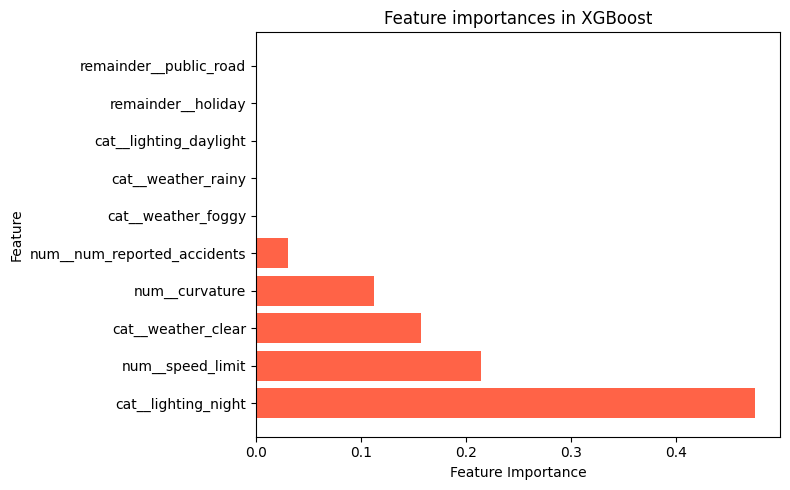

In [24]:
plt.figure(figsize=(8, 5))

plt.barh(df_importances['feature'], df_importances['importance'], color='tomato')

plt.title('Feature importances in XGBoost')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [25]:
submission.head()

,id,accident_risk
0,517754,0.293145
1,517755,0.117790
2,517756,0.183973
3,517757,0.314968
4,517758,0.406235
